In [25]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns

#from sentence_transformers import SentenceTransformer
import umap
# import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

from utils import *

from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map


from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

from sklearn.ensemble import RandomForestClassifier

from sklearn.base import clone as sklearn_clone

from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
import random

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load data

In [26]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_cz.csv', sep=';')

df = df[ df['statementState'] != 'MISLEADING' ]
df = df[ df['statementState'] != 'UNVERIFIABLE' ]

df = df.reset_index(drop=True)

df['assestment'] = df['statementState'].replace({
    'FALSE' : 0,
#     'Manipulacja' : 1,
    'TRUE' : 1
}).astype(int)

y_train = df.copy()['assestment']
X_train = df.copy().loc[:, df.columns != 'assestment']

## Analysis words frequencies

In [27]:
tasks = X_train['text_clean'].values.tolist()
result = progress_map(tokenize, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train['words'] = result

Core 1:   0%|          | 0/345 [00:00<?, ?it/s]

Core 2:   0%|          | 0/345 [00:00<?, ?it/s]

Core 3:   0%|          | 0/345 [00:00<?, ?it/s]

Core 4:   0%|          | 0/345 [00:00<?, ?it/s]

Core 5:   0%|          | 0/345 [00:00<?, ?it/s]

Core 6:   0%|          | 0/345 [00:00<?, ?it/s]

Core 7:   0%|          | 0/345 [00:00<?, ?it/s]

In [28]:
df_one = X_train.copy()

# df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

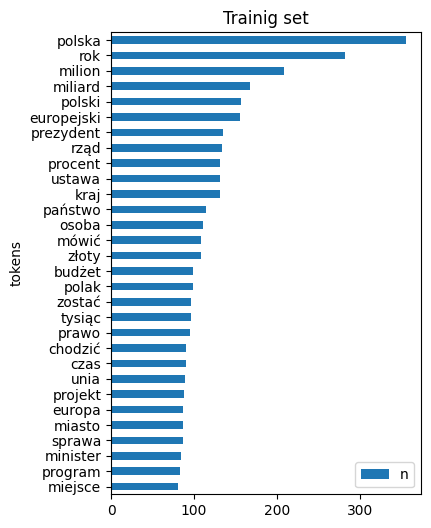

In [29]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(4,6));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

### Remove extra stopwords

In [30]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'milion', 
                        'miliard', 
                        'polski', 'europejski', 
                        'prezydent', 'rząd', 'ustawa', 'procent', 'kraj'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

In [31]:
def filter_stop_words(words, stop_words = extra_stop_words):
    out = [x for x in words if x not in stop_words]
    return out

tasks = X_train['words'].values.tolist()
result = progress_map(filter_stop_words, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train['words_clean'] = result

Core 1:   0%|          | 0/345 [00:00<?, ?it/s]

Core 2:   0%|          | 0/345 [00:00<?, ?it/s]

Core 3:   0%|          | 0/345 [00:00<?, ?it/s]

Core 4:   0%|          | 0/345 [00:00<?, ?it/s]

Core 5:   0%|          | 0/345 [00:00<?, ?it/s]

Core 6:   0%|          | 0/345 [00:00<?, ?it/s]

Core 7:   0%|          | 0/345 [00:00<?, ?it/s]

In [34]:
# X_train['words_clean'] = X_train['words_clean'].apply(lambda x: ' '.join(x))
# X_train['words'] = X_train['words'].apply(lambda x: ' '.join(x))
# X_train['assestment'] = y_train
# X_train[['text_clean', 'words_clean', 'assestment', 'words']].to_csv('../datasets/ready2use/fake_news_features_cz_to_use.csv', sep=';')

### Add features

In [8]:
n_grams = 5
min_pos = 5 

In [9]:
X_pos = X_train[['TEXT_POS']].copy()

words =  sum(X_pos['TEXT_POS'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()
    
col = {}
    
for n in tqdm(n_iterator):
    x = X_pos['TEXT_POS'].str.count(' '.join(n)) / X_pos['TEXT_POS'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
X_pos = pd.concat( [X_pos] + list( col.values() ), axis=1 ).drop('TEXT_POS', axis=1)

100%|███████████████████████████████████████| 4579/4579 [00:50<00:00, 91.03it/s]


In [10]:
X_ngram = X_train[['words_clean']].copy()

X_ngram['words_clean'] = X_ngram['words_clean'].apply(lambda l: " ".join(l))

words =  sum(X_ngram['words_clean'].str.split(' ').values.tolist(), [])

n_list = []
for n in range(n_grams):
    n_i = pd.Series(nltk.ngrams(words, n+1)).value_counts()
    n_i = n_i[n_i>min_pos]
    n_list.append(n_i)

n_iterator = []
for n_i in n_list:
    n_iterator += n_i.index.tolist()

col = {}
    
for n in tqdm(n_iterator):
    x = X_ngram['words_clean'].str.count(' '.join(n)) / X_ngram['words_clean'].str.split(' ').str.len()

    col[' '.join(n)] = x
    col[' '.join(n)].name = ' '.join(n)
            
X_ngram = pd.concat( [X_ngram] + list( col.values() ), axis=1 ).drop('words_clean', axis=1)

100%|██████████████████████████████████████| 1117/1117 [00:09<00:00, 123.76it/s]


## Make balanced datasets

In [11]:
n_0 = y_train.value_counts()[0]
n_1 = y_train.value_counts()[1]

In [12]:
n_lower = y_train.value_counts().min()
n_upper = y_train.value_counts().max()

np.random.seed(111)

if True:
    # undersampling    
    index_0 = np.random.choice(y_train[y_train==0].index, n_lower, replace=False)
    index_1 = np.random.choice(y_train[y_train==1].index, n_lower, replace=False)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    X_pos_u = X_pos.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    X_ngram_u = X_ngram.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
else:
    # oversampling
    if n_0 < n_1:
        index_0 = np.random.choice(y_train[y_train==0].index, n_1, replace=True)
        index_1 = np.random.choice(y_train[y_train==1].index, n_1, replace=False)
    else:
        index_0 = np.random.choice(y_train[y_train==0].index, n_0, replace=False)
        index_1 = np.random.choice(y_train[y_train==1].index, n_0, replace=True)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    X_pos_u = X_pos.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    X_ngram_u = X_ngram.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()

## Create embeddings

In [13]:
word2vec = KeyedVectors.load("../word2vec/word2vec_100_3_polish.bin")

In [14]:
def get_wor2vec_embeddings(words, w2v=word2vec):
    emb = []
    for x in words:
        if x in word2vec.index_to_key:
            emb.append( w2v[x].reshape(1,-1) )
        else:
            emb.append( np.zeros((1,100)) )
    
    if len(emb) == 0:
        out = np.zeros((1,100))
    else:
        out = np.concatenate(emb, axis=0)
    
    return out

tasks = X_train_u['words_clean'].values.tolist()
result = progress_map(get_wor2vec_embeddings, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_u['wor2vec'] = result

X_w2v = X_train_u[['words_clean', 'wor2vec']]

Core 1:   0%|          | 0/186 [00:00<?, ?it/s]

Core 2:   0%|          | 0/186 [00:00<?, ?it/s]

Core 3:   0%|          | 0/186 [00:00<?, ?it/s]

Core 4:   0%|          | 0/186 [00:00<?, ?it/s]

Core 5:   0%|          | 0/186 [00:00<?, ?it/s]

Core 6:   0%|          | 0/186 [00:00<?, ?it/s]

Core 7:   0%|          | 0/186 [00:00<?, ?it/s]

## CV creation
### LDA

In [15]:
ideal_topic_num = 10

In [16]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_u['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

X_train_u['topic'] = topics

100%|█████████████████████████████████████| 1296/1296 [00:00<00:00, 5589.98it/s]


In [17]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.030*"miejsce" + 0.025*"osoba" + 0.024*"tysiąc" + 0.017*"człowiek" + 0.013*"dziecko"
1 0.022*"partia" + 0.015*"deficyt" + 0.014*"drugi" + 0.011*"pis" + 0.010*"projekt"
2 0.040*"wybory" + 0.034*"trybunał" + 0.026*"konstytucyjny" + 0.018*"przyp" + 0.016*"dzień"
3 0.028*"budżet" + 0.019*"pkb" + 0.016*"unia" + 0.014*"państwo" + 0.013*"tysiąc"
4 0.019*"rocznie" + 0.015*"sprawa" + 0.012*"platforma" + 0.012*"pis" + 0.012*"komorowski"
5 0.020*"sędzia" + 0.014*"człowiek" + 0.012*"złoty" + 0.011*"unia" + 0.011*"jedyny"
6 0.024*"liczba" + 0.016*"minister" + 0.015*"osoba" + 0.010*"janusz" + 0.010*"europa"
7 0.034*"euro" + 0.014*"the" + 0.013*"pierwszy" + 0.011*"czas" + 0.011*"podatek"
8 0.032*"polak" + 0.016*"zostać" + 0.015*"ukraina" + 0.014*"praca" + 0.014*"poziom"
9 0.015*"bezrobocie" + 0.015*"program" + 0.011*"nowy" + 0.011*"podatek" + 0.011*"złoty"


In [18]:
y_train_u_test = pd.DataFrame(y_train_u.copy())
y_train_u_test['topic'] = X_train_u['topic']
y_train_u_test['n'] = 1
y_train_u_test.groupby(['topic', 'assestment']).sum().reset_index().pivot('topic','assestment','n')

assestment,0,1
topic,,
0,80,57
1,48,55
2,54,75
3,78,86
4,57,66
5,81,73
6,53,52
7,67,61
8,68,61


### Kfold

In [19]:
cv_fold = []
cv_fold_i = []

for i in X_train_u['topic'].unique().reshape(10,-1):
    train_cv = X_train_u.index[ ~np.isin(X_train_u["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(X_train_u["topic"], i) ].values
    
    train_cv_i = X_train_u.reset_index().index[ ~np.isin(X_train_u["topic"], i) ].values
    test_cv_i = X_train_u.reset_index().index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train_u)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(X_train_u):
    train_cv = X_train_u.iloc[ train_index, : ].index.values
    test_cv = X_train_u.iloc[ test_index, : ].index.values

    train_cv_i= X_train_u.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = X_train_u.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Run experiments

In [21]:
def run_experiment(X, y, cv, clf_org, r_min=0.05):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
    #     clf = RandomForestClassifier(random_state=111)

        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]

        # keep only columns with corr > 0.05
        col_keep = []
        for c in X_train_t.columns:
            min_v =X_train_t[c].values.min()
            max_v = X_train_t[c].values.max()

            if min_v < max_v:
                r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                if ~np.isnan(r) and r > r_min:
                    col_keep.append(c)
        
        if len(col_keep) == 0:
            print('No values returned')
        
        X_train_t = X_train_t[col_keep]


        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]

        X_test_t = X_test_t[col_keep]

        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)

        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

#     print(c_matrix)

    return metrics

In [22]:
def run_experiment_w2v(X, y, cv, clf_org):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)

        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]
        
        vectorizer = TfidfVectorizer()
        vectorizer.fit(X_train_t['words_clean'].apply(lambda l: " ".join(l)).values)
        
        result = []
        for words, vec in X_train_t[['words_clean','wor2vec']].values:
            weigh_vec = []
            for w in words:
                if w in vectorizer.vocabulary_:
                    weigh_vec.append(vectorizer.vocabulary_[w])
                else: 
                    weigh_vec.append(0)
            if vec.shape[0] > 1:
                result.append( np.average(vec, axis=0, weights=weigh_vec).reshape(1, -1) ) 
            else: 
                result.append( vec )

        X_train_emb = np.concatenate(result)
        
        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]
        
        result = []
        for words, vec in X_test_t[['words_clean','wor2vec']].values:
            weigh_vec = []
            for w in words:
                if w in vectorizer.vocabulary_:
                    weigh_vec.append(vectorizer.vocabulary_[w])
                else: 
                    weigh_vec.append(0)
            if vec.shape[0] > 1:
                result.append( np.average(vec, axis=0, weights=weigh_vec).reshape(1, -1) ) 
            else: 
                result.append( vec )
                
        X_test_emb = np.concatenate(result)
        
        
        clf.fit(X_train_emb, y_train_t)

        y_pred = clf.predict(X_test_emb)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

#     print(c_matrix)

    return metrics

In [23]:
X_features = X_train_u[['sentiment_all', 'sentiment_avg', 'uniq_words',
       'uniq_lemm', 'err', 'net', 'words_start_upper', 'words_full_upper',
       'exclamation_marks', 'question_marks', 'upper_letters', 'chars']]

## Topics Kfold

In [24]:
X_f_pos = X_features.reset_index().join(X_pos_u.reset_index(drop=True), how="left").set_index('index')

In [25]:
random.seed(111)

In [26]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    for clf_used, clf_name in zip(
        [clf_lr_1],['lr C1']
    ):
        out = run_experiment(X_used, y_train_u, cv_fold, clf_used, 0.05)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
            f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
            f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )

out = run_experiment_w2v(X_w2v, y_train_u, cv_fold, clf_lr_1)
print(
    'word2vec lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

ngrams   lr C1 Accuracy 0.515+-0.034 F1 Score 0.501+-0.076  0.515+-0.034 | 0.501+-0.076
features lr C1 Accuracy 0.509+-0.032 F1 Score 0.454+-0.067  0.509+-0.032 | 0.454+-0.067
pos      lr C1 Accuracy 0.561+-0.049 F1 Score 0.558+-0.049  0.561+-0.049 | 0.558+-0.049
f + pos  lr C1 Accuracy 0.545+-0.059 F1 Score 0.549+-0.060  0.545+-0.059 | 0.549+-0.060
word2vec lr C1 Accuracy 0.519+-0.039 F1 Score 0.527+-0.047  0.519+-0.039 | 0.527+-0.047


## Random Kfold

In [27]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
        
for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    for clf_used, clf_name in zip(
        [clf_lr_1],['lr C1']
    ):
        out = run_experiment(X_used, y_train_u, cv_Kfold, clf_used, 0.03)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
            f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
            f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
out = run_experiment_w2v(X_w2v, y_train_u, cv_Kfold, clf_lr_1)
print(
    'word2vec lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

ngrams   lr C1 Accuracy 0.528+-0.044 F1 Score 0.508+-0.056  0.528+-0.044 | 0.508+-0.056
features lr C1 Accuracy 0.522+-0.029 F1 Score 0.466+-0.051  0.522+-0.029 | 0.466+-0.051
pos      lr C1 Accuracy 0.563+-0.033 F1 Score 0.559+-0.046  0.563+-0.033 | 0.559+-0.046
f + pos  lr C1 Accuracy 0.544+-0.043 F1 Score 0.540+-0.055  0.544+-0.043 | 0.540+-0.055
word2vec lr C1 Accuracy 0.516+-0.023 F1 Score 0.519+-0.020  0.516+-0.023 | 0.519+-0.020


## Use all features 

In [ ]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

scoring = ['accuracy', 'precision', 'recall', 'f1']

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    
    col_keep = []
    for c in X_used.columns:
        min_v =X_used[c].values.min()
        max_v = X_used[c].values.max()

        if min_v < max_v:
            r = scipy.stats.pearsonr(X_used[c].values, y_train_u)[0]
            if ~np.isnan(r) and r > 0.05:
                col_keep.append(c)
                    
    results = cross_validate(estimator=clf_lr_1,
                           X=X_used[col_keep],
                           y=y_train_u,
                           cv=cv_fold_i, #10,
                           scoring=scoring,
                           return_train_score=True)
    print(
        x_name, 
        'lr C1',
        f'Accuracy {results["test_accuracy"].mean():.3f}+-{results["test_accuracy"].std():.3f}',
        f'F1 Score {results["test_f1"].mean():.3f}+-{results["test_f1"].std():.3f}',
    )

In [ ]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

scoring = ['accuracy', 'precision', 'recall', 'f1']

for X_used, x_name in zip(
    [X_ngram_u, X_features, X_pos_u, X_f_pos],
    ['ngrams  ', 'features', 'pos     ', 'f + pos ']
):
    
    col_keep = []
    for c in X_used.columns:
        min_v =X_used[c].values.min()
        max_v = X_used[c].values.max()

        if min_v < max_v:
            r = scipy.stats.pearsonr(X_used[c].values, y_train_u)[0]
            if ~np.isnan(r) and r > 0.05:
                col_keep.append(c)
                    
    results = cross_validate(estimator=clf_lr_1,
                           X=X_used[col_keep],
                           y=y_train_u,
                           cv=cv_Kfold_i, #10,
                           scoring=scoring,
                           return_train_score=True)
    print(
        x_name, 
        'lr C1',
        f'Accuracy {results["test_accuracy"].mean():.3f}+-{results["test_accuracy"].std():.3f}',
        f'F1 Score {results["test_f1"].mean():.3f}+-{results["test_f1"].std():.3f}',
    )